# Spherical Harmonic Gravity Model and Mean Orbital Elements

## Introduction
This scenario showcases the use of spherical harmonics for higher fidelity modelling of Earth's gravitational field. The scenario propagates a spacecraft in Low Earth Orbit and compares the spacecraft's osculating classical orbit elements with the mean orbital elements calculated using the first order Brower technique outlined in:
*Schaub, H., & Junkins, J. L. (2003). First-order Mapping between Mean and Osculating Orbit Elements. In Analytical Mechanics of Space Systems (pp. 693–696)*.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from nominalpy import types
from nominalpy.maths import astro, utils
from nominalpy.maths.constants import RPM
# from nominalpy.maths.utils import random_mrp
from nominalpy.maths.constellations import CoplanarCircular
from nominalpy import Simulation, Object

import credential_helper

In [2]:
# define the simulation constants
planet = "earth"
degree_order = 10
req = astro.get_planet_property(planet, 'REQ')
j2 = astro.get_planet_property(planet, 'j2')
# define the simulation parameters
sim_duration = 10800  # s
sim_step = 1.0  # s
subscribe_step = 60.0  # s

rows = int(sim_duration / subscribe_step)
print(f"Number of rows: {rows}")

Number of rows: 180


## Defining the Initial Conditions
In this scenario the initial orbital elements of the spacecraft are set from their mean orbital elements in order to compare the output mean and osculating orbital elements to this input. This is done by defining them within the input variables of the function used to convert them to osculating elements. The initial state of the simulation has to be initialised as an osculating state vector. Therefore, the osculating classical orbital elements can be converted into their equivalent state vector which can then be used to initialise the spacecraft object.

In [3]:
# define the osculating classic orbital elements from input mean elements
orbit: tuple = astro.mean_to_osculating_elements(
    req=req,  # m^3/s^2
    j2=j2,
    semi_major_axis=7000000,  # m
    eccentricity=0.00001,
    inclination=np.radians(30.0),  # rad
    right_ascension=np.radians(48.2),  # rad
    argument_of_periapsis=np.radians(347.8),  # rad
    true_anomaly=np.radians(85.3),  # rad
    mean_to_osculating=True,
)
# convert the osculating elements to state vectors
state = astro.classical_to_vector_elements(
    semi_major_axis=orbit[0],
    eccentricity=orbit[1],
    inclination=orbit[2],
    right_ascension=orbit[3],
    argument_of_periapsis=orbit[4],
    true_anomaly=orbit[5],
    planet=planet,
)

In [4]:
# Construct the credentials
credentials = credential_helper.fetch_credentials()

# Create a simulation handle
simulation: Simulation = Simulation.get(credentials)

## Configuring the Simulation
Every simulation has a universe object. We can configure the universe to have a specific epoch.

nominalpy enales users to invoke methods to further configure the simulation. In this case, we can set the spherical harmonics for the universe object.

In [5]:
from datetime import datetime

# configure the universe
universe: Object = simulation.get_system(
    types.SOLAR_SYSTEM,
    Epoch=datetime(2022, 1, 15)
)
# set the spherical harmonics
universe.invoke("SetSphericalHarmonics", planet, degree_order, "GGM03S.txt")

'True'

## Adding the Spacecraft
The spacecraft object is added to the simulation. The spacecraft object is configured with the initial state vector and the spacecraft's properties.

In [6]:
# configure the spacecraft
spacecraft = simulation.add_object(
    types.SPACECRAFT,
    TotalMass=750.0,  # kg
    TotalCenterOfMassB_B=np.array([0, 0, 0]),  # m
    TotalMomentOfInertiaB_B=np.diag([900.0, 800.0, 600.0]),  # kg m^2
    Position=state[0],
    Velocity=state[1],
    Attitude=np.array([0.1, 0.2, -0.3]),  # MRP
    AttitudeRate=np.array([0.001, -0.01, 0.03]),  # rad/s
)

## Subscribing to the Messages
The spacecraft object is subscribed to the messages of interest. In this case, the spacecraft is subscribed to the Out_BodyStatesMsg message which gives the translational and rotational states of the spacecraft recorded at a frequency defined by the input subscribe_step.

In [7]:
# subscribe to the messages of interest
simulation.set_tracking_interval(subscribe_step)
simulation.track_object(spacecraft.get_message("Out_SpacecraftStateMsg"))

## Propagating the Spacecraft
The spacecraft is propagated for a duration defined by the input sim_duration and a step defined by the input sim_step. The spacecraft is propagated in batch mode which will propagate the scenario in batches.

In [8]:
# propagate the spacecraft
simulation.tick_duration(time=sim_duration, step=sim_step)

In [9]:
df_state = simulation.query_dataframe(spacecraft.get_message("Out_SpacecraftStateMsg"))

def _convert(x):
    r_bn_n=x.loc[["Position_BN_N_0", "Position_BN_N_1", "Position_BN_N_2"]].values
    v_bn_n=x.loc[["Velocity_BN_N_0", "Velocity_BN_N_1", "Velocity_BN_N_2"]].values
    # define the mean classical orbital elements
    coe_mean = astro.vector_to_classical_elements_mean(
        r_bn_n=r_bn_n,
        v_bn_n=v_bn_n,
        planet=planet,
    )
    # define the osculating classical orbital elements
    coe = astro.vector_to_classical_elements(
        r_bn_n=r_bn_n,
        v_bn_n=v_bn_n,
        planet=planet,
    )
    return pd.Series({
        "time": x["Time"],
        "semi_major_axis_mean": coe_mean[0],
        "eccentricity_mean": coe_mean[1],
        "inclination_mean": coe_mean[2],
        "right_ascension_mean": coe_mean[3],
        "argument_of_periapsis_mean": coe_mean[4],
        "true_anomaly_mean": coe_mean[5],
        "argument_of_latitude_mean": utils.normalize_angle(coe_mean[4] + coe_mean[5]),
        "semi_major_axis_osc": coe[0],
        "eccentricity_osc": coe[1],
        "inclination_osc": coe[2],
        "right_ascension_osc": coe[3],
        "argument_of_periapsis_osc": coe[4],
        "true_anomaly_osc": coe[5],
        "argument_of_latitude_osc": utils.normalize_angle(coe[4] + coe[5]),
    })

df_coe = df_state.apply(_convert, axis=1)

## Plotting the Results

### Plotting the Mean and Osculating Semi-Major Axis
The mean and osculating semi-major axis are plotted against time. 

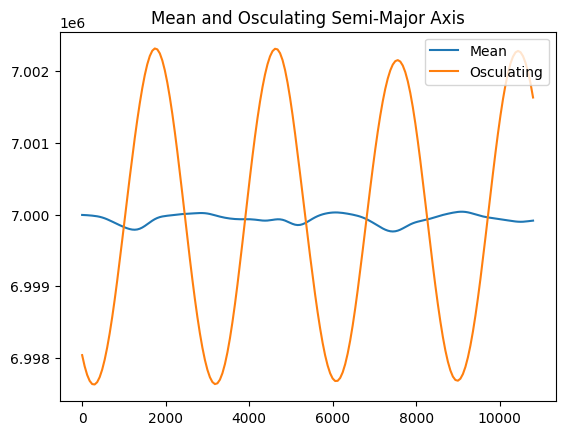

In [10]:
# plot the mean and osculating semi-major axis
fig, ax = plt.subplots()
# add the mean semi-major axis to the plot
ax.plot(
    df_coe.loc[:, "time"].values, 
    df_coe.loc[:, "semi_major_axis_mean"].values, 
    label="Mean"
)
# add the osculating semi-major axis to the plot
ax.plot(
    df_coe.loc[:, "time"].values, 
    df_coe.loc[:, "semi_major_axis_osc"].values, 
    label="Osculating"
)
# add a title to the plot
ax.set_title("Mean and Osculating Semi-Major Axis")
# add a legend to the plot
ax.legend()
